# Confusion Matrix Uncertainty

While the approach described here is not based on this paper, the approach here is similar to this recent work: https://link.springer.com/content/pdf/10.1007%2Fs10472-017-9564-8.pdf

In [1]:
%pylab inline
import pandas as pd
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sim_preds(n=100):
    p = np.random.beta(1,2,n)
    u = np.random.uniform(0,1,n)
    y = p >= u
    return p, y*1.0

def binary_cv_metrics(cm):
    m = {}
    m['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
    m['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
    m['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
    m['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
    m['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
    m['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)
    return m

def cm_posterior_sample(cm,n_samples=5000):
    alpha = cm.reshape(4,) + 1
    samp = np.random.dirichlet(alpha, n_samples) * (cm.sum() - 1) 
    cm_samples = samp.reshape(n_samples,2,2)
    return cm_samples

def get_sample_metrics_df(cm_samples):
    metrics_samples = pd.DataFrame([binary_cv_metrics(cms) for cms in cm_samples])
    return metrics_samples

def get_posterior_mean_ci(metrics_samples,ci=95):
    metrics_mean_ci = {}
    quantiles = np.array([(100-ci)/2., 100 - (100-ci)/2.]) / 100.
    for metric in metrics_samples.columns:
        metrics_mean_ci[metric] = metrics_samples[metric].mean()
        lower, upper = metrics_samples[metric].quantile(quantiles)
        metrics_mean_ci[metric + ' lower'] = lower
        metrics_mean_ci[metric + ' upper'] = upper
    return metrics_mean_ci

In [3]:
# simulate data and compute confusion matrix
n = 50
thresh = 0.5
p, y = sim_preds(n)
pred = p > thresh
cm = metrics.confusion_matrix(y, pred)

# Sample from the posterior distribution of confusion matricies
cm_samples = cm_posterior_sample(cm)

# Compute the metrics for each sample from the posterior
metrics_samples = get_sample_metrics_df(cm_samples)

# Compute the mean and CI of the posteriors
metrics_mean_ci = get_posterior_mean_ci(metrics_samples)

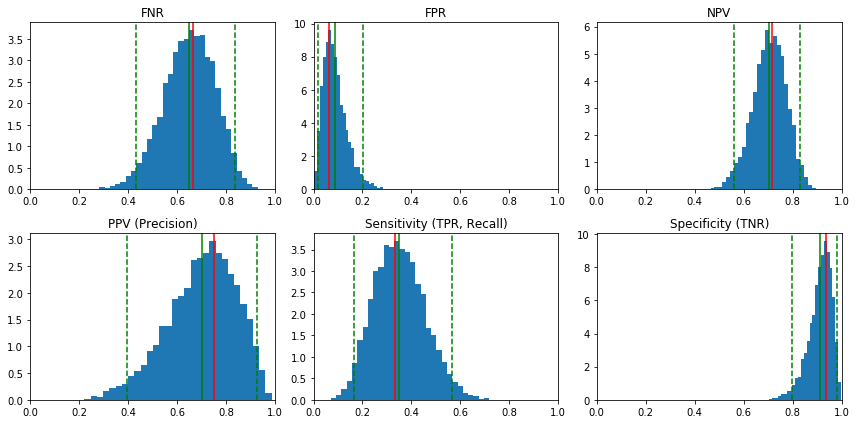

In [5]:
fig, axx = plt.subplots(2,3,figsize=(12,6))
est_metric = binary_cv_metrics(cm)
for i,metric in enumerate(metrics_samples.columns):
    ax = axx[i//3,i%3]
    ax.hist(metrics_samples[metric],bins=30,normed=True)
    ax.set_title(metric)
    ax.set_xlim(0,1)
    ylim = ax.get_ylim()
    ax.axvline(est_metric[metric],ylim[0],ylim[1],color='red')
    ax.axvline(metrics_mean_ci[metric],ylim[0],ylim[1],color='green')
    ax.axvline(metrics_mean_ci[metric + ' lower'],ylim[0],ylim[1],color='green',ls='--')
    ax.axvline(metrics_mean_ci[metric + ' upper'],ylim[0],ylim[1],color='green',ls='--')
fig.tight_layout()
plt.show()

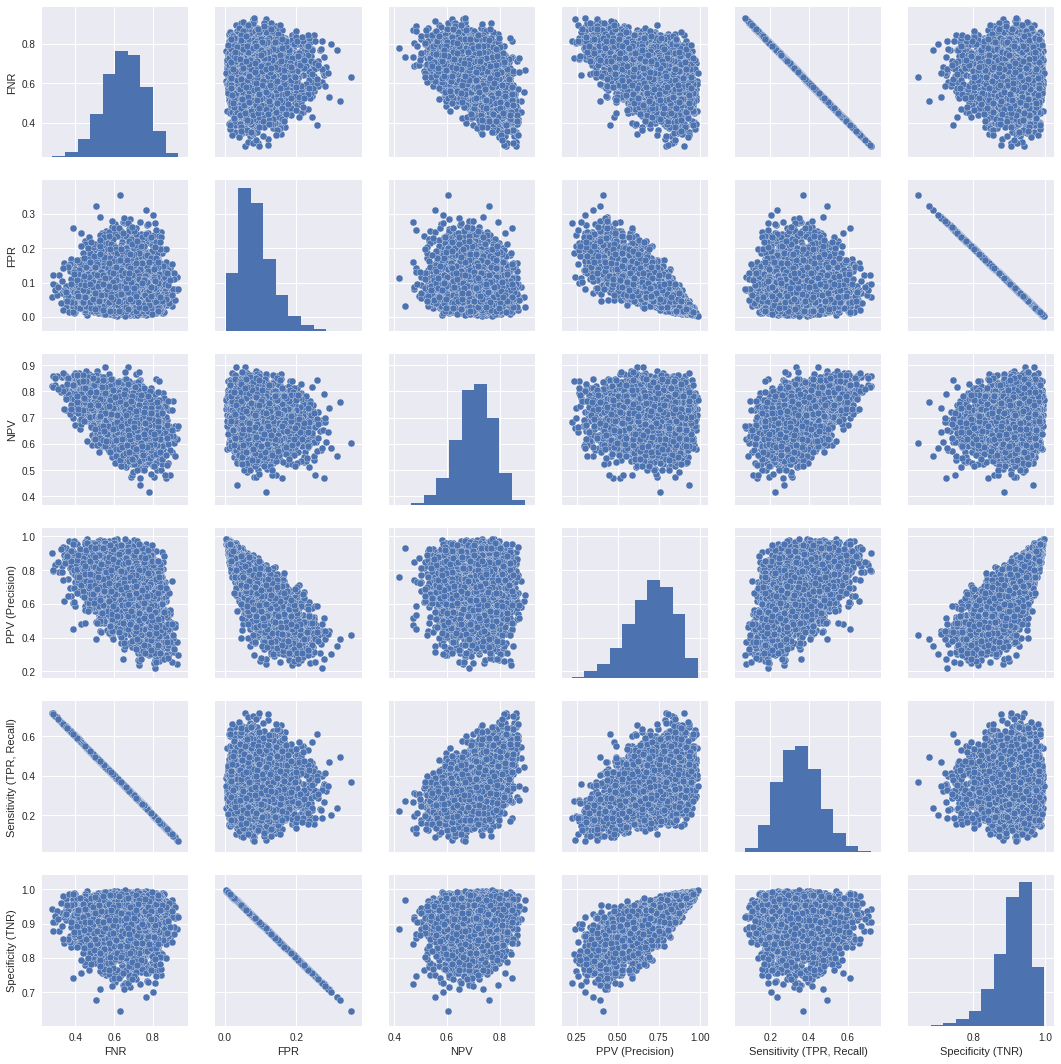

In [6]:
import seaborn as sns
sns.pairplot(metrics_samples)